# FLux.jl MNIST example

Training a Convolutional Neural Network (CNN) against the famous MNIST dataset of handwritten digits. Much of the credit for this notebook should go to this [blog](https://www.freecodecamp.org/news/deep-learning-with-julia/) and its code published on [github](https://github.com/AndreyGermanov/phones_reader).

In [1]:
# Packages
using Pkg
Pkg.activate(".")
#Pkg.instantiate()
using Images
using Flux
using ZipFile
using BSON
using Plots, Measures
using JLD

# optional gpu usage
const use_gpu = true
if use_gpu
    using CUDA
end

  Activating project at `~/src_nobackup/julia_ml_tests.jl.git`


In [2]:
# mnist images from [this archive](https://www.kaggle.com/datasets/jidhumohan/mnist-png)
# we have a copy in the data directory
data_root = "data"
zip_file = "archive.zip"

function mkdir_p(path) # make directory and parents if needed
    if !isdir(path)
        # check for parent directory
        if !(path=="/" || path=="")
            parentDir = dirname(path)
            if !isdir(parentDir)
                mkdir_p(parentDir)
            end
        end
        mkdir(path)
    end
end

if !isdir(joinpath(data_root,"mnist_png"))
    zarchive = ZipFile.Reader(joinpath(data_root,zip_file))
    for f in zarchive.files
        if contains(f.name,"mnist_png/mnist_png") # the has two copies of the data
            continue
        end
        println(f.name)
        fullFilePath = joinpath(data_root,f.name)
        if endswith(f.name,"/")
            println("creating directory: ",fullFilePath)
            mkdir_p(fullFilePath)
        else
            println("creating file: ",fullFilePath)
            # check for parent directory
            parentDir = dirname(fullFilePath)
            if !isdir(parentDir)
                println("creating directory: ",parentDir)
                mkdir_p(parentDir)
            end
            out =  open(fullFilePath,"w")
            write(out,read(f,String))
            close(out) 
        end
    end
    close(zarchive)
end

# paths with images and labels
training_images_path = joinpath(data_root,"mnist_png","training")
testing_images_path = joinpath(data_root,"mnist_png","testing")

nothing

In [34]:

# Function that loads images from files and returns a dataset
function createDataset(path,number_of_images)
    X = zeros(Float32,28,28,1,number_of_images) # 28x28x1 is the size of the images, one channel
    y = zeros(Float32,number_of_images)
    icount = 0
    for label in readdir(path)
        println("Loading label $(label) from path $(path)")
        for file in readdir(joinpath(path,label))
            icount += 1
            if icount%1000 == 0
                println("$(icount): Loading file $(file) from path $(path)/$(label)")
            end
            img = load(joinpath(path,label,file))
            data = reshape(Float32.(channelview(img)),28,28,1)
            X[:,:,1,icount] = data
            y[icount]= parse(Float32,label)
        end
    end
    return X,y
end;

# Load the dataset
if !isfile("data/mnist.jld")
    x_train,y_train = createDataset(training_images_path,60000);
    x_test,y_test = createDataset(testing_images_path,10000);
    @save "data/mnist.jld" x_train y_train x_test y_test
else
    @load "data/mnist.jld" x_train y_train x_test y_test
end

y_train_onehot = Flux.onehotbatch(y_train, 0:9)
y_test_onehot = Flux.onehotbatch(y_test, 0:9);  

# Output is copy of input for autoencoder
z_train = copy(x_train)
z_test = copy(x_test);

In [35]:
# Limit the size of the training set
# Note that training set is not shuffled. It has eg all the zeros at the start
n_train = 10000
idx = rand(1:size(x_train,4),n_train)
x_train = x_train[:,:,:,idx]
y_train = y_train[idx]
z_train = z_train[:,:,:,idx]

nothing

In [36]:
# distort x_train with number_of_images
noise_amplitude = 0.1
noise = noise_amplitude*randn(size(x_train))
x_train = x_train + noise

28×28×1×10000 Array{Float64, 4}:
[:, :, 1, 1] =
 -0.0318421   -0.00825701  -0.0412569   …   0.120577     0.0756832
  0.0610493   -0.0318412    0.127422       -0.134951    -0.0181847
 -0.0752648   -0.0497333    0.102681       -0.0115217   -0.0567863
  0.00537225  -0.0359559   -0.211428        0.0843797    0.0297114
  0.0051963    0.00903679   0.0203608       0.223853    -0.186145
 -0.037737     0.112634     0.0497379   …   0.101334    -0.0149536
 -0.123152    -0.041335     0.0300837       0.00991311  -0.026427
  0.0419493    0.126383     0.189589       -0.0761263   -0.00720133
 -0.00284742  -0.0963361   -0.0578236      -0.0556171    0.0701256
  0.170958    -0.0538154   -0.0769001      -0.0964357   -0.0499981
  ⋮                                     ⋱               
  0.149872    -0.0743757    0.0867932       0.0296499   -0.0376454
  0.0525934   -0.0820779    0.0566822   …  -0.0533246    0.0542
 -0.11023      0.0834389   -0.284713        0.0884851   -0.00883194
 -0.0337427    0.216698    

In [37]:
# move data to gpu
if use_gpu
    x_train_gpu = gpu(x_train)
    z_train_gpu = gpu(z_train)
    x_test_gpu = gpu(x_test)
    z_test_gpu = gpu(z_test)
else
    x_train_gpu = x_train
    z_train_gpu = z_train
    x_test_gpu = x_test
    z_test_gpu = z_test
end

nothing

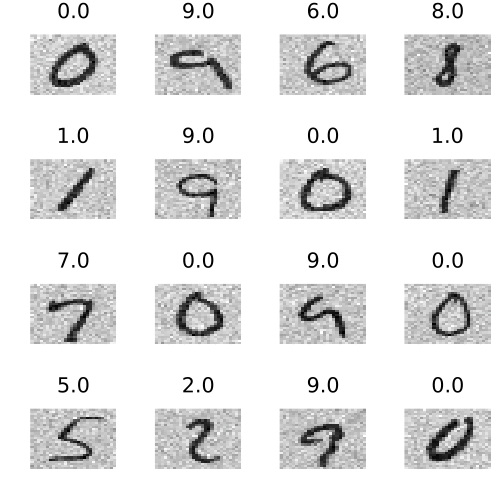

In [38]:
n_train,n_test = size(x_train)[end],size(x_test)[end]
# show a few images
#heatmap(1f0.-x_train[:,:,1,1],size=(100,100),legend=false,showaxis=false,color=:greys,margin=0mm,title="$(y_train[1])")
plot_array = []
for i = 1:4, j = 1:4
    i_rand = rand(1:n_train)
    h=heatmap(1f0.-reverse(x_train[:,:,1,i_rand],dims=1),size=(100,100),legend=false,showaxis=false,color=:greys,margin=0mm,title="$(y_train[i_rand])")
    push!(plot_array, h)
end
plot(plot_array..., layout = (4,4), size = (500, 500))

In [39]:

# Define a convolutional autoencoder
encoder = Chain(
    Conv((5,5),1 => 8, relu,pad=SamePad()),
    MaxPool((2,2)),
    Conv((5,5),8 => 16, relu,pad=SamePad()),
    MaxPool((2,2)),
) 
decoder = Chain(
    Conv((5,5),16 => 8, relu,pad=SamePad()),
    Upsample((2,2)),
    Conv((5,5),8 => 8, relu,pad=SamePad()),
    Upsample((2,2)),
    Conv((5,5),8 => 1, σ,pad=SamePad()),
)

autoencoder = Chain(encoder=encoder, decoder=decoder)
model = autoencoder

if use_gpu
    model_gpu = gpu(model)
else
    model_gpu = model
end

nothing
     


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Conv((5, 5), 1 => 8, relu, pad=2)
│   summary(x) = 28×28×1×2 Array{Float64, 4}
└ @ Flux /home/verlaan/.julia/packages/Flux/r3RWW/src/layers/stateless.jl:60


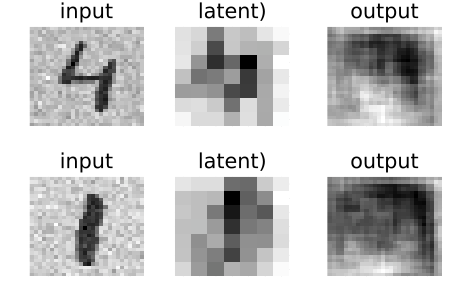

In [40]:
x_small = x_train[:,:,:,1:2]
l_small = encoder(x_small) # latent space
z_small_hat = decoder(l_small)
z_small = z_train[:,:,:,1:2]

# plot the latent space
function plot_enc_dec(left,mid,right,labels=("input","latent","output"))
        plot_array = []
        n_samples = size(left)[end]
        for i=1:n_samples
                # left
                img1 = 1f0.-reverse(left[:,:,1,i],dims=1)
                h=heatmap(img1,size=(100,100),legend=false,showaxis=false,
                        color=:greys,margin=0mm,title="$(labels[1])")
                push!(plot_array, h)
                # middle
                img2 = 1f0.-reverse(mid[:,:,1,i],dims=1)
                h=heatmap(img2,size=(100,100),legend=false,showaxis=false,
                        color=:greys,margin=0mm,title="$(labels[2]))")
                push!(plot_array, h)
                # right
                img3 = 1f0.-reverse(right[:,:,1,i],dims=1)
                h=heatmap(img3,size=(100,100),legend=false,showaxis=false,
                        color=:greys,margin=0mm,title="$(labels[3])")
                push!(plot_array, h)
        end
        plot(plot_array..., layout = (n_samples,3), size = (3*150, n_samples*150))
end
plot_enc_dec(x_small,l_small,z_small_hat,("input","latent","output"))

In [41]:
# Loss and accuracy

# Define the loss function that uses the cross-entropy to 
# measure the error by comparing model predictions of data 
# row "x" with true data from labels vector "y" in one hot encoding
function loss(model, x, z)
	return Flux.mse(model(x),z)
end

# test 
loss1 = loss(model, x_small, z_small)
loss1_gpu = loss(model_gpu, x_small |>gpu, z_small |>gpu)
loss1, loss1_gpu

(0.2544617f0, 0.2544618f0)

In [42]:
# setup data loader for training data
# Assemble the training data
const batchsize = 128
if use_gpu
	train_data = Flux.DataLoader((x_train_gpu,z_train_gpu), shuffle=true, batchsize=batchsize)
else
	train_data = Flux.DataLoader((x_train,z_train), shuffle=true, batchsize=bathcsize)
end
train_data

79-element DataLoader(::Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}}, shuffle=true, batchsize=128)
  with first element:
  (28×28×1×128 CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, 28×28×1×128 CuArray{Float32, 4, CUDA.Mem.DeviceBuffer},)

In [43]:
# initial loss
l_train=loss(model_gpu,x_train_gpu,z_train_gpu)

0.25083712f0

In [44]:

# Initialize the ADAM optimizer with default settings
optimizer = Flux.setup(Adam(0.0001),model_gpu)

# Train the model
# and display the accuracy on each
# iteration
for epoch in 1:30
	Flux.train!(loss, model_gpu, train_data, optimizer)
    println("epoch: $(epoch)") #NOTE: we careless with compute, rerunning model each time below
    println("   Loss for training    : $(loss(model_gpu,x_train_gpu,z_train_gpu))")
    println("   Loss for testing     : $(loss(model_gpu,x_test_gpu,z_test_gpu))")
end


epoch: 1


   Loss for training    : 0.14147967


   Loss for testing     : 0.15075351


epoch: 2


   Loss for training    : 0.09542773


   Loss for testing     : 0.09992642


epoch: 3


   Loss for training    : 0.054306425


   Loss for testing     : 0.05752241


epoch: 4


   Loss for training    : 0.04254057


   Loss for testing     : 0.045625266


epoch: 5


   Loss for training    : 0.035007652


   Loss for testing     : 0.0385185


epoch: 6


   Loss for training    : 0.029439628


   Loss for testing     : 0.032941137


epoch: 7


   Loss for training    : 0.025560938


   Loss for testing     : 0.028518073


epoch: 8


   Loss for training    : 0.022937292


   Loss for testing     : 0.025722338


epoch: 9


   Loss for training    : 0.021032214


   Loss for testing     : 0.022921598


epoch: 10


   Loss for training    : 0.019682532


   Loss for testing     : 0.02241667


epoch: 11


   Loss for training    : 0.018465023


   Loss for testing     : 0.019943878


epoch: 12


   Loss for training    : 0.017508786


   Loss for testing     : 0.018871376


epoch: 13


   Loss for training    : 0.016665677


   Loss for testing     : 0.018236788


epoch: 14


   Loss for training    : 0.015957693


   Loss for testing     : 0.017691843


epoch: 15


   Loss for training    : 0.015327633


   Loss for testing     : 0.016738607


epoch: 16


   Loss for training    : 0.014760295


   Loss for testing     : 0.016072685


epoch: 17


   Loss for training    : 0.014270259


   Loss for testing     : 0.015238462


epoch: 18


   Loss for training    : 0.013832673


   Loss for testing     : 0.015478978


epoch: 19


   Loss for training    : 0.013384822


   Loss for testing     : 0.014909641


epoch: 20


   Loss for training    : 0.012964756


   Loss for testing     : 0.014211716


epoch: 21


   Loss for training    : 0.0126415985


   Loss for testing     : 0.013178302


epoch: 22


   Loss for training    : 0.0122775715


   Loss for testing     : 0.012931145


epoch: 23


   Loss for training    : 0.011950395


   Loss for testing     : 0.012631587


epoch: 24


   Loss for training    : 0.011645038


   Loss for testing     : 0.012397277


epoch: 25


   Loss for training    : 0.01137396


   Loss for testing     : 0.012457653


epoch: 26


   Loss for training    : 0.011104506


   Loss for testing     : 0.011852051


epoch: 27


   Loss for training    : 0.01093127


   Loss for testing     : 0.012298274


epoch: 28


   Loss for training    : 0.01062503


   Loss for testing     : 0.011549285


epoch: 29


   Loss for training    : 0.0104155075


   Loss for testing     : 0.011410373


epoch: 30


   Loss for training    : 0.010207829


   Loss for testing     : 0.011198282


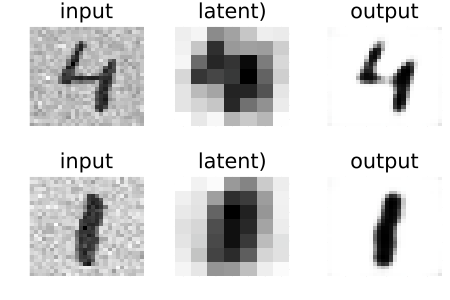

In [49]:
#Plot some results
model_trained = cpu(model_gpu)
encoder_trained = model_trained[:encoder]
decoder_trained = model_trained[:decoder]
x_small = x_train[:,:,:,1:2]
l_small = encoder_trained(x_small) # latent space
z_small_hat = decoder_trained(l_small)
z_small = z_train[:,:,:,1:2]

plot_enc_dec(x_small,l_small,z_small_hat,("input","latent","output"))


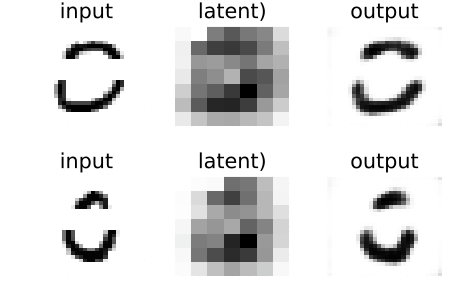

In [48]:
# Distort the input
n_small=2 
x_small_dist = copy(x_test[:,:,:,1:n_small])
x_small_dist[10:15,:,1,:] .= 0f0
l_small_dist = encoder_trained(x_small_dist) # latent space
z_small_dist_hat = decoder_trained(l_small_dist)

plot_enc_dec(x_small_dist,l_small_dist,z_small_dist_hat,("input","latent","output"))